In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
data_dir = "skin-cancer-data"

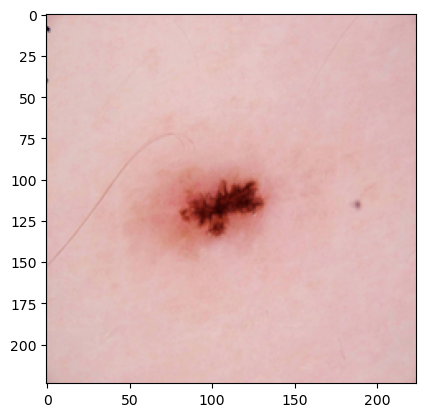

In [27]:
import matplotlib.image as mpimg
test_image = "skin-cancer-data/benign/1.jpg"
img = mpimg.imread(test_image)
plt.imshow(img)

In [28]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [31]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

{'benign': 0, 'malignant': 1}

In [37]:
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(200,200,3)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2,2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(32)])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 99, 99, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 153664)            0         
                                                                 
 dense (Dense)               (None, 32)                4917280   
                                                                 
Total params: 4,936,672
Trainable params: 4,936,672
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
type(tf_img_data1)
type(tf_img_data2)

tensorflow.python.framework.ops.EagerTensor

In [48]:
# x = tf_img_data1
# y = tf_img_data1

In [50]:
model.fit(x=tf_img_data1, y=tf.cast(list(map(int, target_val)), tf.int32), epochs=5)

ValueError: Data cardinality is ambiguous:
  x sizes: 2637
  y sizes: 660
Make sure all arrays contain the same number of samples.